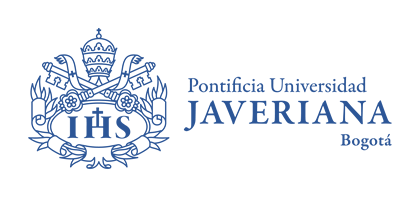

# Aprendizaje profundo - Taller 2
Este notebook tiene como objetivo familiarizar al estudiante con un ambiente de aprendizaje por refuerzo bajo el API de OpenAI Gym



En el segundo taller del curso se utilizará el framework OpenAI Gym y Tensorflow Agents para crear una red neuronal profunda que resuelva un cubo de rubik de 2x2x2 utilizando el gimnasio RubiksCubeGym disponible [en github siguiendo este link](https://github.com/DoubleGremlin181/RubiksCubeGym)



Este notebook utiliza instrucciones del tutorial **Train a Deep Q Network with TF-Agents** disponible en este [link](https://colab.research.google.com/github/tensorflow/agents/blob/master/docs/tutorials/1_dqn_tutorial.ipynb#scrollTo=pmDI-h7cI0tI)  


## Setup
Se instalan y se importan las librerías necesarias para el ejercicio

In [1]:
!sudo apt-get update
!sudo apt-get install -y xvfb ffmpeg
!pip install 'imageio==2.4.0'
!pip install pyvirtualdisplay
!pip install tf-agents
!pip install rubiks-cube-gym
!pip install tf-agents[reverb]
!pip install pyglet

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease [1,581 B]
Get:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:6 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages [787 kB]
Get:8 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:10 http://security.ubuntu.com/ubuntu bionic-security/multiverse amd64 Packages [22.8 kB]
Get:11 http://security.ubuntu.com/ubuntu bionic-security/restricted amd64 Packages [954 kB]
Hit:13 http://ppa.launchpad.n

In [2]:
!rm -fr dl-taller02-rubik
!git clone https://github.com/javierrojas6/dl-taller02-rubik
!tar -xzvf dl-taller02-rubik/data-compressed/rubiks_cube_222_states_FRU.tar.gz
!mv rubiks_cube_222_states_FRU.pickle /usr/local/lib/python3.7/dist-packages/rubiks_cube_gym/envs

Cloning into 'dl-taller02-rubik'...
remote: Enumerating objects: 8, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 8 (delta 0), reused 8 (delta 0), pack-reused 0
Unpacking objects: 100% (8/8), done.
rubiks_cube_222_states_FRU.pickle


In [3]:
from __future__ import absolute_import, division, print_function

import base64
import imageio
import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import pyvirtualdisplay
import reverb
from datetime import datetime

import tensorflow as tf

from rubiks_cube_gym.envs.rubiks_cube_222 import RubiksCube222Env

from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import py_driver
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import sequential
from tf_agents.policies import py_tf_eager_policy
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.specs import tensor_spec
from tf_agents.utils import common
from tf_agents.trajectories import time_step as ts
from tf_agents.networks.q_network import QNetwork
from tf_agents.replay_buffers import reverb_replay_buffer
from tf_agents.replay_buffers import reverb_utils

In [4]:
env_name = "rubiks-cube-222-jav-v0" #@param {type:"string"}
num_iterations = 20000 #@param {type:"integer"}

initial_collect_steps = 100 #@param {type:"integer"}
collect_steps_per_iteration = 30 #@param {type:"integer"}
replay_buffer_max_length = 100000 #@param {type:"integer"}

batch_size = 64 #@param {type:"integer"}
learning_rate = 1e-3 #@param {type:"number"}
log_interval = 200 #@param {type:"integer"}

num_eval_episodes = 20 #@param {type:"integer"}
eval_interval = 1000 #@param {type:"integer"}
discount = 0.5 #@param {type:"number"}
fps = 5 #@param {type:"integer"}

num_parallel_calls = 10 #@param {type:"integer"}
num_steps = 2 #@param {type:"integer"}
sequence_length = 30 #@param {type:"integer"}



In [5]:
class NaiveRubiksCube222(RubiksCube222Env):
  solved = "WWWWOOGGRRBBOOGGRRBBYYYY"
  orderedColors = "WOGRBY"

  def __init__(self):
      super(NaiveRubiksCube222, self).__init__()

  def reward(self):
      if self.cube_reduced == self.solved:
        print("reward: ", 100)
        return 100, True

      reward = 0
      for i in range(0, len(self.cube_reduced)):
          reward += self.solved[i] == self.cube_reduced[i]

      faces = self.splitFaces(self.cube_reduced)
      for i, face in enumerate(faces):
          if face == [self.orderedColors[i]] * 4:
              reward += 10

      return reward, False

  def splitFaces(self, reduced):
      lst = list(reduced) 
      return [
          lst[:4],
          lst[4:6] + lst[12:14],
          lst[6:8] + lst[14:16],
          lst[8:10] + lst[16:18],
          lst[10:12] + lst[18:20],
          lst[20:24],
      ]

from gym.envs.registration import register

register(
    id=env_name,
    entry_point='__main__:NaiveRubiksCube222',
    max_episode_steps=250,
)


In [6]:
def compute_avg_return(environment, policy, num_episodes=10):
  total_return = 0.0
  for _ in range(num_episodes):
    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward

    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]

## Entrenamiento y ajuste de redes neuronales profundas con el agente

Para continuar con el taller, revise el notebook **Train a Deep Q Network with TF-Agents** disponible en este [link](https://colab.research.google.com/github/tensorflow/agents/blob/master/docs/tutorials/1_dqn_tutorial.ipynb#scrollTo=pmDI-h7cI0tI). Allí se muestra como crear un agente de TensorFlow a partir de un gimnasio de OpenAI gym, el entrenamiento y test de una red Deep Q Network. 

Se espera que complete los siguientes puntos:

1. **[30%]** Extensión de la recompensa del ambiente del gimnasio para resolver el problema. (Se evalúa sobre el notebook o notebooks entregados, no olvide añadir celdas de texto para explicar y documentar su código) 
2. **[35%]** Plantear una red Deep-Q network para resolver el problema. Esto incluye experimentar con diferentes arquitecturas y factores de descuento para la red del agente. Pruebe el desempeño de cada agente en términos de la recompensa promedio obtenida. (Se evalúa sobre el notebook o notebooks entregados, no olvide añadir celdas de texto para explicar y documentar su código)
3. **[35%]** Informe de taller: Realice un informe del taller en el que documente la función de recompensa escogida, la experimentación realizada sobre la red Deep Q network y los resultados obtenidos. No olvide colocar sus conclusiones: ¿Qué aprendió con este taller? ¿Qué cosas funcionaron bien? ¿Qué cosas no funcionaron bien?  

### Lo que su grupo debe entregar: 

Archivo zip que contenga:

Informe, nombrado Informe-taller2.pdf, en formato IEEE transactions on artficial intelligence con lo solicitado en el punto 3. Límite de 10 páginas que no incluyen la bibliografía. (12 páginas si realiza el bono) 

Carpeta src con notebook o notebooks desarrollados para resolver el problema 

Archivo readme.txt con los nombres de los integrantes del grupo 


 



In [7]:
train_py_env = suite_gym.load(env_name, discount)
eval_py_env  = suite_gym.load(env_name, discount)

train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

observation_tensor_spec = tensor_spec.from_spec(train_py_env.observation_spec())
action_tensor_spec = tensor_spec.from_spec(train_py_env.action_spec())
time_step_tensor_spec = ts.time_step_spec(observation_tensor_spec)

In [8]:
fc_layer_params = (10000,5000, 100, 3)
# fc_layer_params = (300, 150, 100, 50, 20, 3)
# fc_layer_params = (1000, 750, 500, 250, 100, 50, 20, 3)
# fc_layer_params = (5000, 2000, 1000, 750, 500, 250, 100, 50, 20, 3)

q_net = QNetwork(
  input_tensor_spec = observation_tensor_spec,
  action_spec = action_tensor_spec,
  preprocessing_layers=None,
  preprocessing_combiner=None,
  conv_layer_params=None,
  fc_layer_params=fc_layer_params,
  dropout_layer_params=None,
  activation_fn=tf.keras.activations.relu,
  kernel_initializer=tf.keras.initializers.RandomUniform(minval=-0.03, maxval=0.03),
  batch_squash=True,
  dtype=tf.float32,
  name='QNetwork'
)

In [9]:
agent = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=tf.Variable(0))

agent.initialize()

In [10]:
table_num = 0
eval_policy = agent.policy
collect_policy = agent.collect_policy

random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())

table_name = 'uniform_table' + str(table_num)
replay_buffer_signature = tensor_spec.from_spec(
      agent.collect_data_spec)
replay_buffer_signature = tensor_spec.add_outer_dim(
    replay_buffer_signature)

table = reverb.Table(
    table_name,
    max_size=replay_buffer_max_length,
    sampler=reverb.selectors.Uniform(),
    remover=reverb.selectors.Fifo(),
    rate_limiter=reverb.rate_limiters.MinSize(1),
    signature=replay_buffer_signature)

reverb_server = reverb.Server([table])

replay_buffer = reverb_replay_buffer.ReverbReplayBuffer(
    agent.collect_data_spec,
    table_name=table_name,
    sequence_length=sequence_length,
    local_server=reverb_server)

rb_observer = reverb_utils.ReverbAddTrajectoryObserver(
  replay_buffer.py_client,
  table_name,
  sequence_length=sequence_length)

py_driver.PyDriver(
    train_py_env,
    py_tf_eager_policy.PyTFEagerPolicy(random_policy, use_tf_function=True),
    [rb_observer],
    max_steps=initial_collect_steps).run(train_py_env.reset())

dataset = replay_buffer.as_dataset(
    num_parallel_calls=num_parallel_calls,
    sample_batch_size=batch_size,
    num_steps=num_steps).prefetch(3)

iterator = iter(dataset)

In [ ]:
start_time = datetime.now()
# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

# Reset the train step.
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = [avg_return]
losses = []

# Reset the environment.
time_step = train_py_env.reset()

# Create a driver to collect experience.
collect_driver = py_driver.PyDriver(
    train_py_env,
    py_tf_eager_policy.PyTFEagerPolicy(
      agent.collect_policy, use_tf_function=True),
    [rb_observer],
    max_steps=collect_steps_per_iteration)

for _ in range(num_iterations):
  # Collect a few steps and save to the replay buffer.
  time_step, _ = collect_driver.run(time_step)

  # Sample a batch of data from the buffer and update the agent's network.
  experience, unused_info = next(iterator)
  train_loss = agent.train(experience).loss
  losses.append(train_loss)

  step = agent.train_step_counter.numpy()

  if step % log_interval == 0:
    print('step = {0}: loss = {1}'.format(step, train_loss))

  if step % eval_interval == 0:
    avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
    print('step = {0}: Average Return = {1}'.format(step, avg_return))
    returns.append(avg_return)

time_elapsed = datetime.now() - start_time

print('Time elapsed (hh:mm:ss.ms) {}'.format(time_elapsed))

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))
step = 200: loss = 45.16379165649414
step = 400: loss = 65.81465911865234
step = 600: loss = 62.406131744384766
step = 800: loss = 39.351016998291016
step = 1000: loss = 50.03422546386719
step = 1000: Average Return = 1696.4000244140625
step = 1200: loss = 48.094635009765625
step = 1400: loss = 41.183780670166016
step = 1600: loss = 39.70852279663086
step = 1800: loss = 37.85992431640625
step = 2000: loss = 41.30781555175781
step = 2000: Average Return = 1925.300048828125
step = 2200: loss = 38.59738540649414
step = 2400: loss = 33.31711196899414
step = 2600: loss = 38.56495666503906
step = 2800: loss = 38.87821578979492
step = 3000: loss = 34.45664978027344
step = 3000: Average Return = 1518.5999755859375
step = 3200: loss = 31.482616424560547
step = 3400

In [ ]:
iterations = range(0, num_iterations + 1, eval_interval)
plt.plot(iterations, returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')
#plt.ylim(top=250)
plt.show()

plt.plot(range(num_iterations), losses)
plt.ylabel('Loss')
plt.xlabel('Iterations')
#plt.ylim(top=250)
plt.show()

In [ ]:
compute_avg_return(eval_env, agent.policy, num_eval_episodes)

In [ ]:
def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)

In [ ]:
def create_policy_eval_video(policy, filename, num_episodes=5, fps=30):
  filename = filename + ".mp4"
  with imageio.get_writer(filename, fps=fps) as video:
    for _ in range(num_episodes):
      time_step = eval_env.reset()
      video.append_data(eval_py_env.render())
      while not time_step.is_last():
        action_step = policy.action(time_step)
        time_step = eval_env.step(action_step.action)
        video.append_data(eval_py_env.render())
  return embed_mp4(filename)

create_policy_eval_video(agent.policy, "trained-agent", num_eval_episodes, fps)

In [ ]:
create_policy_eval_video(random_policy, "random-agent", num_eval_episodes, fps)